# COVID-19 Tracker
Using data on COVID-19 from the European Centre for Disease Control (via the website ourworldindata.org), and world population data from the World Bank, and the Python programming language and Jupyter (IPython) Notebook, I generated some charts to help visualize the data. You can skim the code below, and jumpt to the bottom to see the summary charts.

I have made this source code available as open source on the code sharing service GitHub (see https://github.com/bakirl/covid19-tracker) . You can also launch a Jupyter notebook live in your browser using the service called binder (see https://mybinder.org/v2/gh/bakirl/covid19-tracker/master) - this will take a few minutes to launch, after which you can click on the file (covid19.ipynb). Using this code, you can change things such as the countries and range of dates, etc.

## The Code

In [1]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [2]:
# filter warnings, for now!
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Download latest Covid 19 data
df = pd.read_csv("https://covid.ourworldindata.org/data/ecdc/full_data.csv")

# Downloaded population from World Bank
# http://api.worldbank.org/v2/en/indicator/SP.POP.TOTL?downloadformat=csv
pop = pd.read_csv("population.csv", skiprows=4)
pop = pop.set_index('Country Name')
pop = pop['2018'].dropna()

In [4]:
# Default values
values_def = 'new_cases'
since_def = '2020-03-01'
countries_def=['Italy','Spain','United Kingdom','Ireland','China','United States','Iran']

# Set the default size for the figures
plt.rcParams["figure.figsize"] = (14, 10)

In [5]:
# @global df - data frame containing Covid 19 data by date and by country
# @global pop - data frome containing population data from 2018
# @param values - one of 'new cases', 'total cases', 'new deaths', total deaths'
# @param since - show data only for dates since this date; format 'yyyy-mm-dd'
# @param countries - show data only for the specified countries
# @param by_pop - set to True to divide numbers by population per country, in millions
def covid(values=values_def, since=since_def, countries=countries_def, by_pop=False, sort=True):
    # filter by date
    df2 = df[df.date >= since]
    # generate a pivot chart
    piv = df2.pivot(index='date', columns='location', values=values)
    # filter by country
    if (countries == []):
        sub = piv.drop(columns='World')
    else:
        sub = piv[countries]
    # setup title of plot
    title=values + " since " + since
    if (by_pop):
        # divide each number by the population, in millions
        pop2 = pop[countries]
        pop2 = pop2/1e6
        pop2 = pop2.transpose()
        sub = sub/pop2.values
        title = title + " per million of population"
    if (sort):
        # sort based on highest value on the most recent date (last row)
        lastrow = sub.shape[0]-1
        lastrow_name = sub.index[lastrow]
        sub.sort_values(by=lastrow_name, axis=1, ascending=False, inplace=True)
    return sub, title

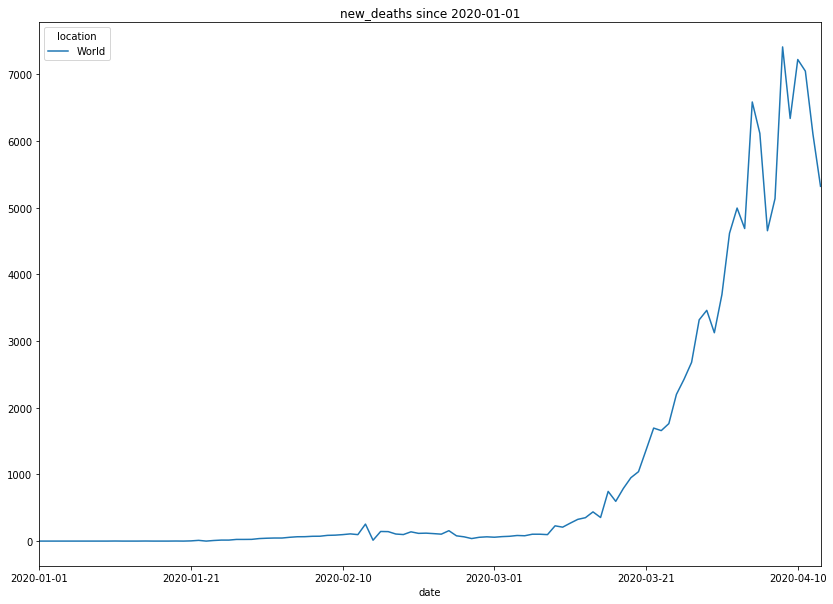

In [6]:
sub, title = covid(values='new_deaths',countries=['World'],since='2020-01-01')
sub.plot(title=title,logy=False)

In [7]:
# generate the sub-pivot for all countries in the covid dataframe
sub, title = covid(countries=[])

# not all countries in the covid dataframe are also in the population dataframe
# find the intersection of these two sets
countries_inter_index = pop.index.intersection(sub.columns)
countries_inter = countries_inter_index.values

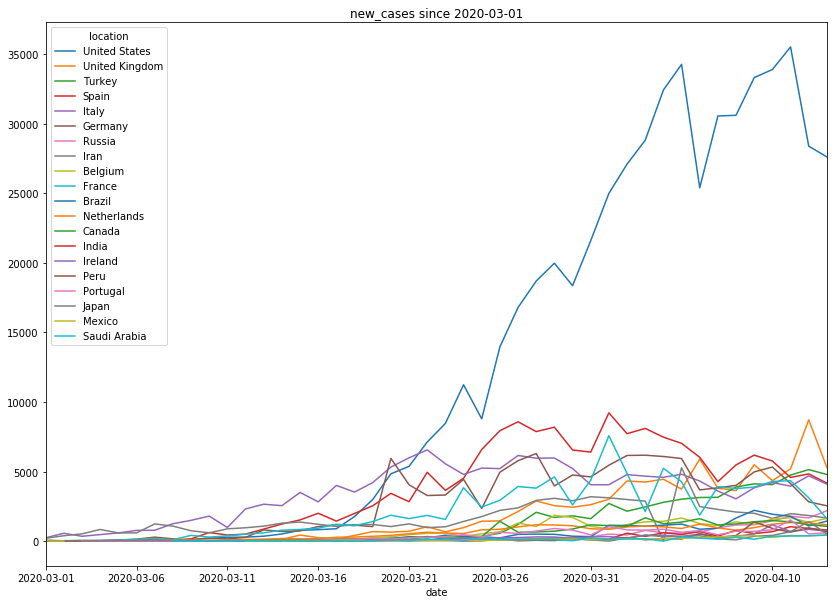

In [8]:
# look at top 20 countries
sub, title = covid(countries=[])
sub = sub.iloc[:,:20]
sub.plot(title=title,logy=False)

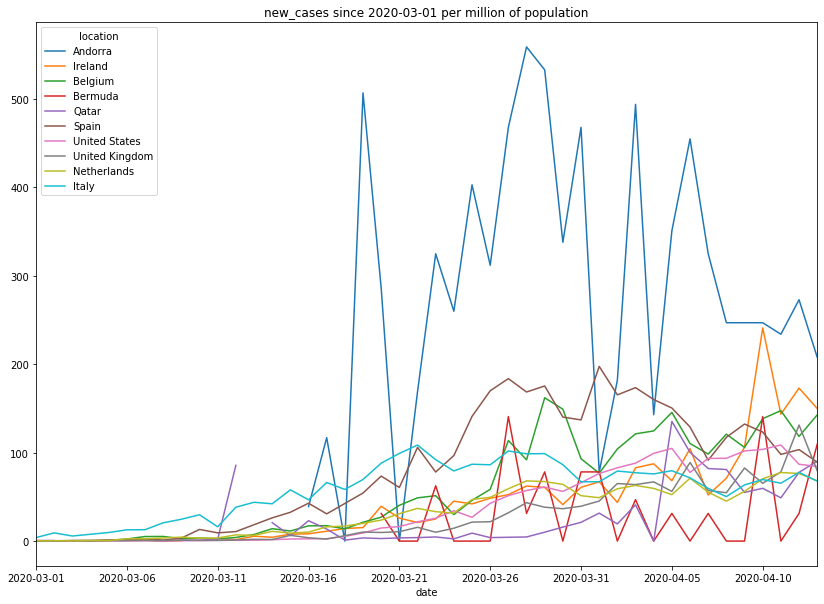

In [9]:
# look at top 20 countries, by population
sub, title = covid(countries=countries_inter, by_pop=True)
sub = sub.iloc[:,:10]
sub.plot(title=title,logy=False)

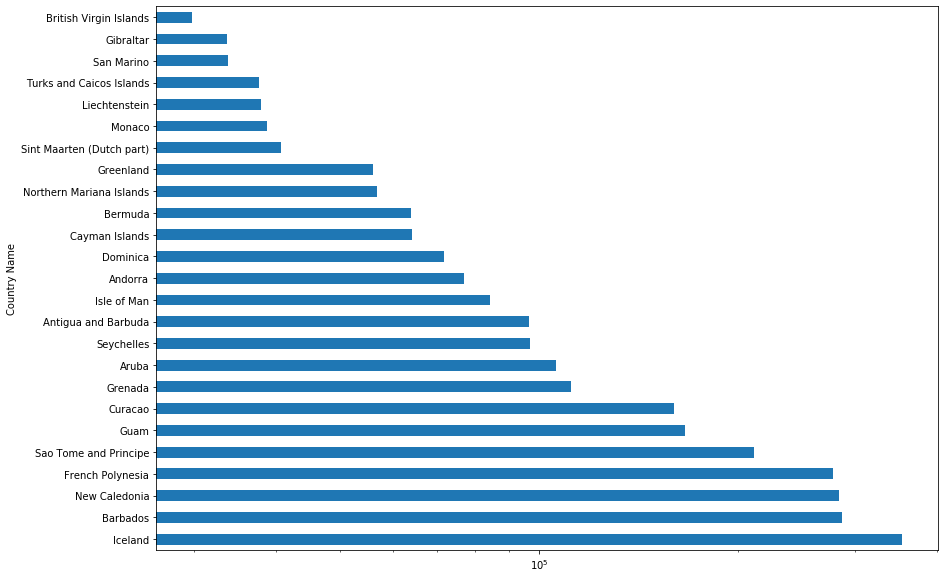

In [10]:
# Countries with smaller populations are showing up - let's look at 40 countries with the smallest population
pop2=pop[countries_inter].sort_values(ascending=False)
entries=pop2.shape[0]
pop2.iloc[entries-25:].plot(kind='barh',logx=True)

In [11]:
# Let's only consider countries with population greater than 1m
countries_small = pop2[pop2.values <= 1e6]
countries_large_index = countries_inter_index.difference(countries_small.index)
countries_large = countries_large_index.values

# Summary Charts
Now let's use this code to visualize the data.

Note that in all cases, the legend lists the countries in descending order (largest first) based on the latest date. 

## Top 10 Countries
First, we look at the number of new cases, total cases, new deaths, and total deaths per country since 1 March 2020. In each case, the top 20 countries are shown.

In [12]:
def covid_plot(n=10, countries=countries_inter, by_pop=False, sort=True, suptitle='', colors=[]):
    plt.rcParams["figure.figsize"] = (14, 10)
    fig, ax = plt.subplots(2, 2, linewidth=5, edgecolor='black')
    fig.tight_layout(pad=8)
    if (suptitle==''):
        suptitle = 'Top ' + str(n) + ' Countries'
    if (by_pop):
        suptitle += ', by Population'
    fig.suptitle(suptitle, size=18, weight='bold')
    for values, axis in zip(['new_cases', 'total_cases', 'new_deaths', 'total_deaths'], [ax[0][0], ax[0][1], ax[1][0], ax[1][1]]):
        sub, title = covid(countries=countries, by_pop=by_pop, values=values, sort=sort)
        if (colors == []):
            ax1 = sub.iloc[:,:n].plot(title=title, logy=False, ax=axis, rot=20)
        else:
            ax1 = sub.iloc[:,:n].plot(title=title, logy=False, ax=axis, rot=20, colors=colors)
        ax1.grid(color='grey', linestyle='-', linewidth=0.5, alpha=0.5, axis='both')

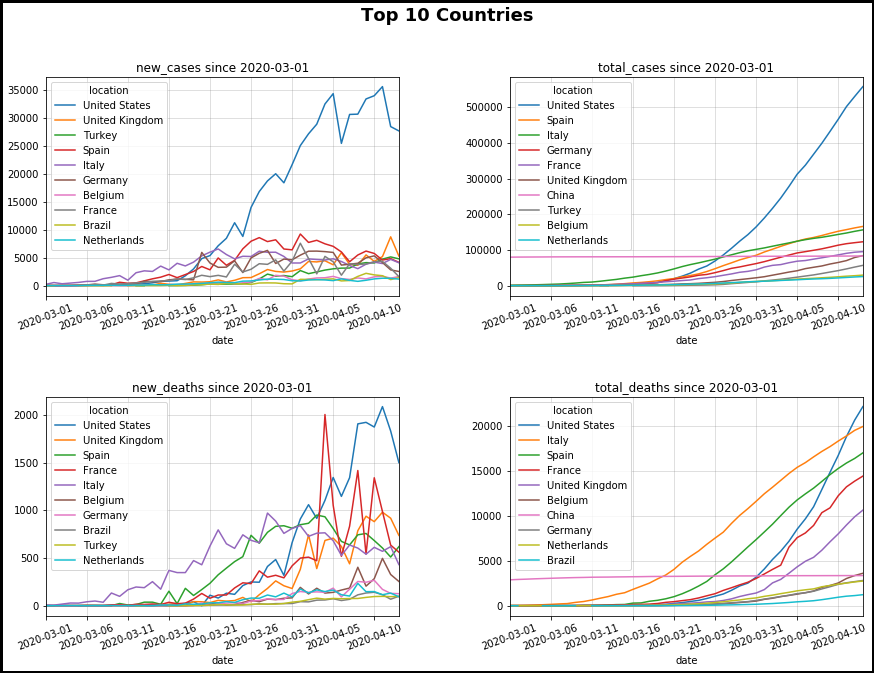

In [13]:
covid_plot()

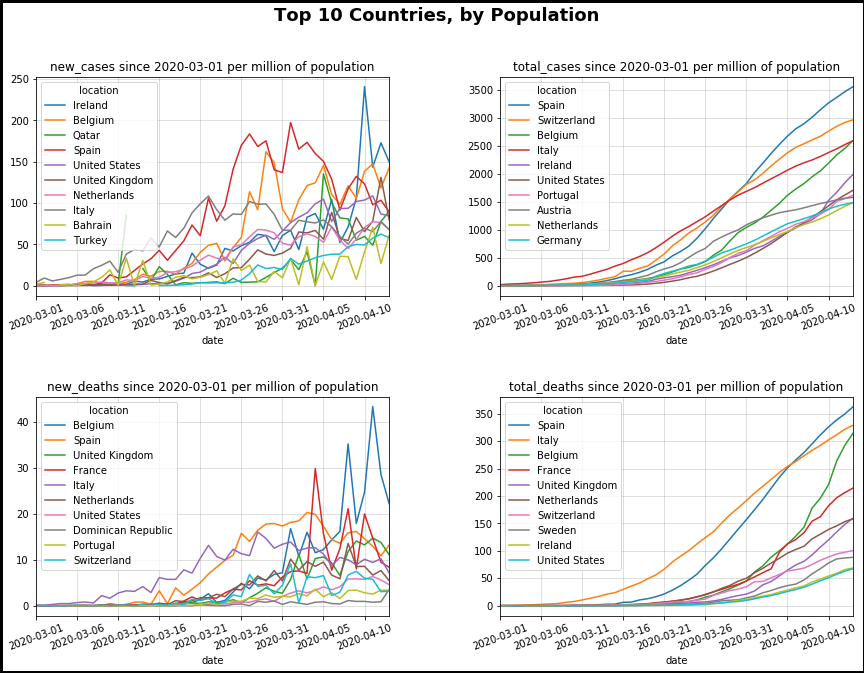

In [14]:
# when sorting by population, exclude smaller countries
covid_plot(by_pop=True, countries=countries_large)

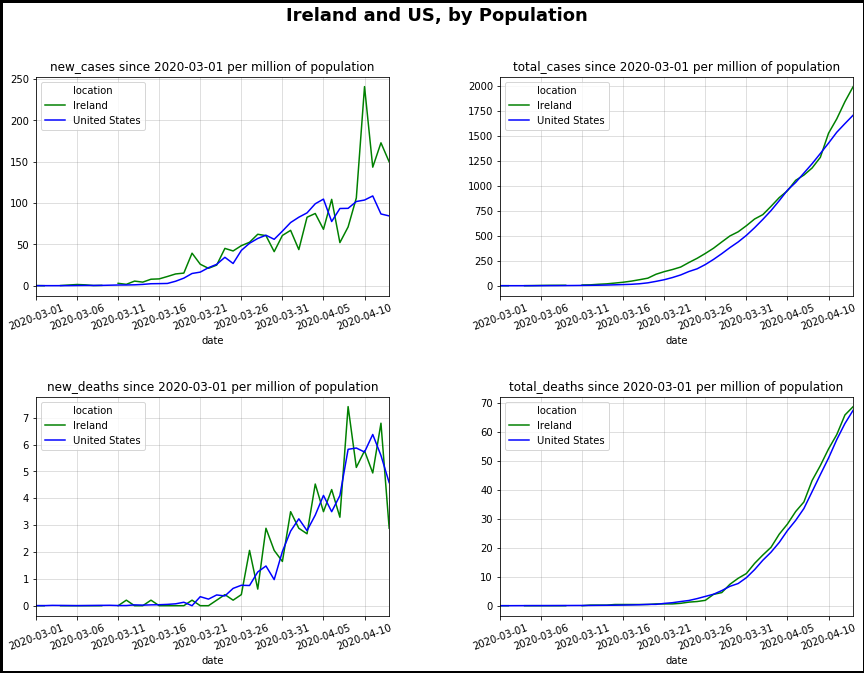

In [15]:
covid_plot(countries=['Ireland','United States'], 
           colors=['green','blue'],
           suptitle='Ireland and US',
           sort=False, by_pop=True)

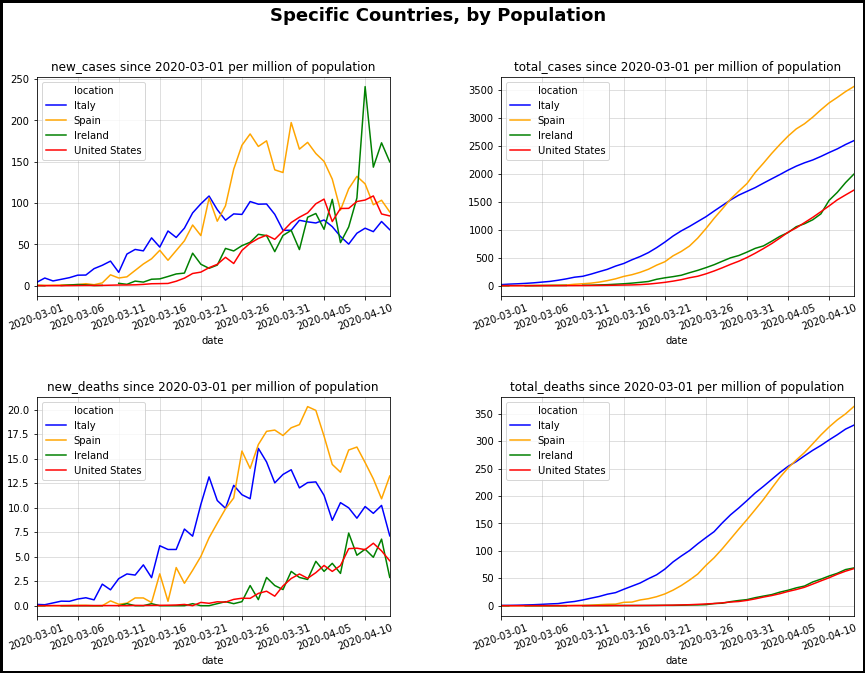

In [16]:
covid_plot(countries=['Italy','Spain','Ireland', 'United States'], 
           colors=['blue','orange','green','red'],
           sort=False, suptitle='Specific Countries', by_pop=True)

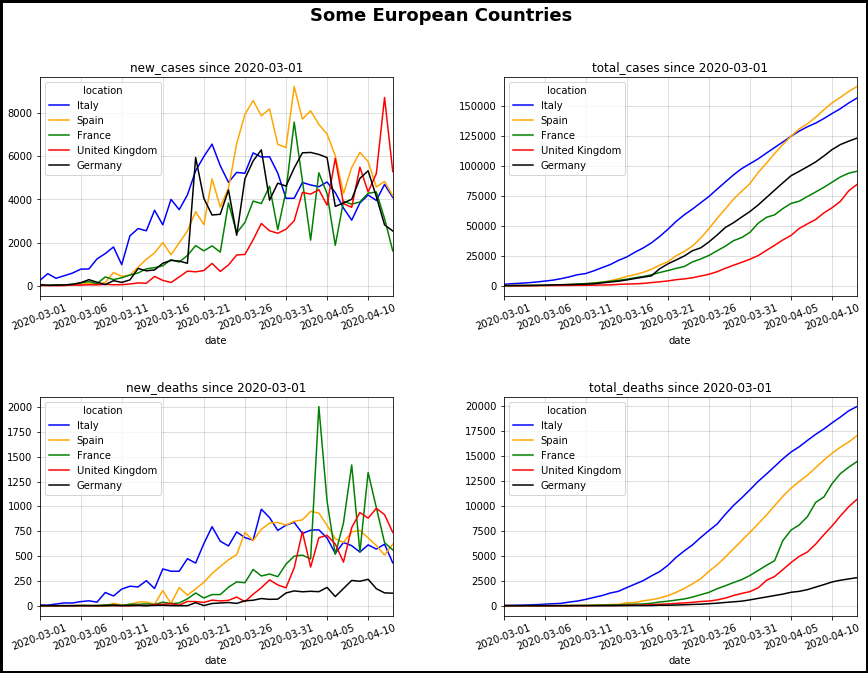

In [17]:
covid_plot(countries=['Italy','Spain','France','United Kingdom','Germany'],
           colors=['blue','orange','green','red','black'],
           suptitle='Some European Countries', sort=False)

## Specific Countries
We now look at some specific countries. 

### China, South Korea, United States, Ireland - Separate Charts
A few things to note:

* The date on these is from 1 Jan, rather than 1 Mar, above. This is because China's cases started earlier.
* I have shown these on separate graphs, because they all have different scales (even when scaled by population).

As future tasks, I plan to try to "time shift" to some relevant time. 

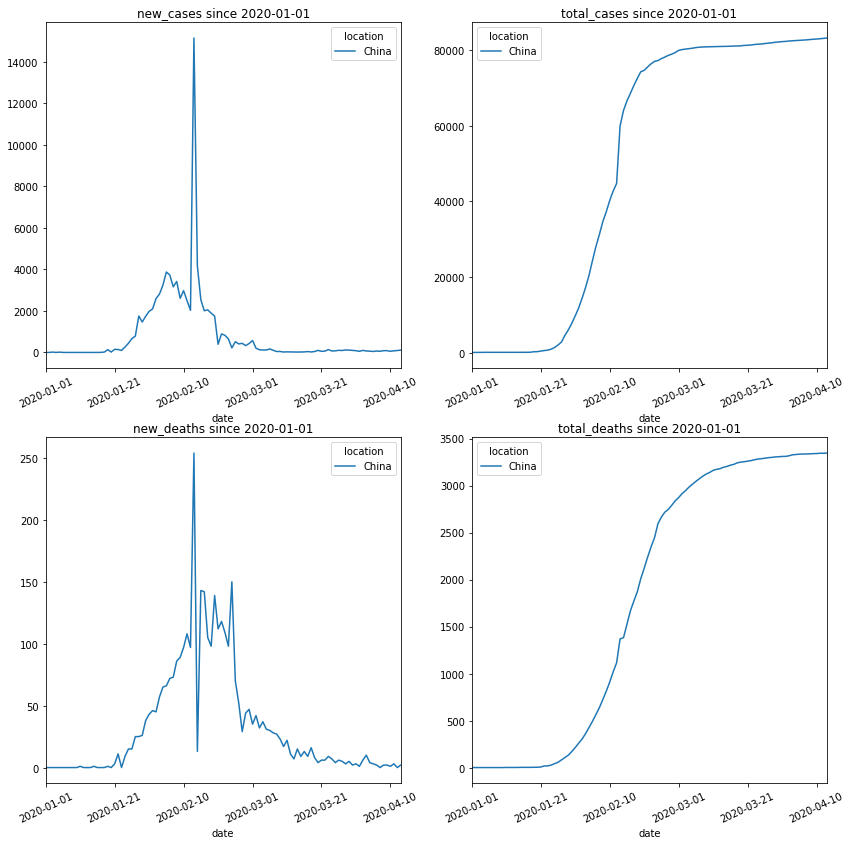

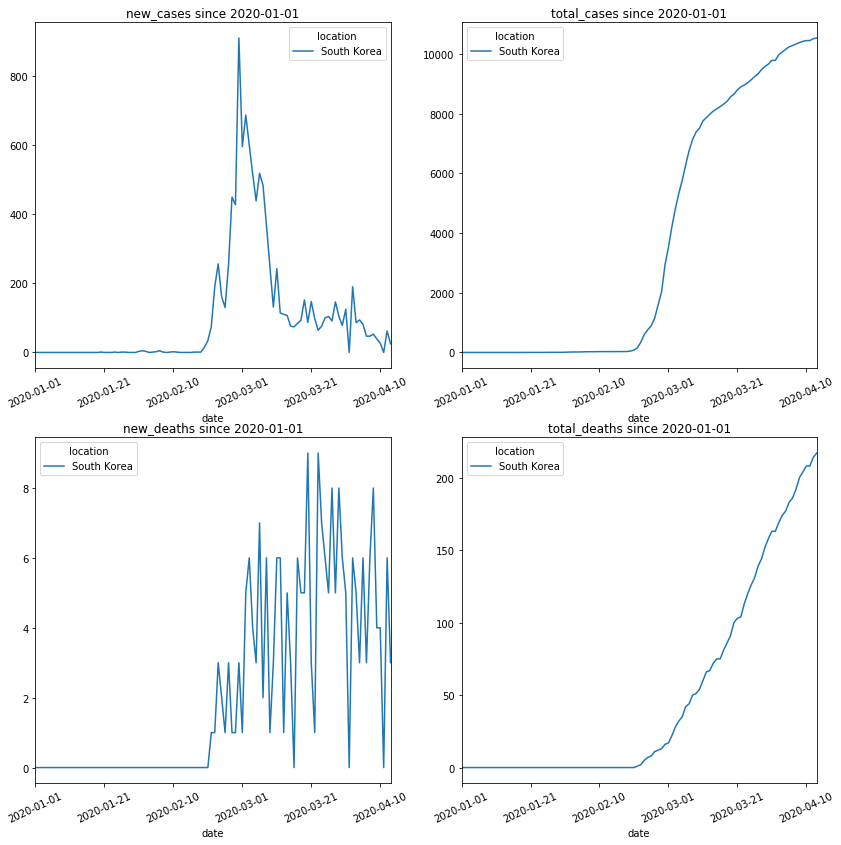

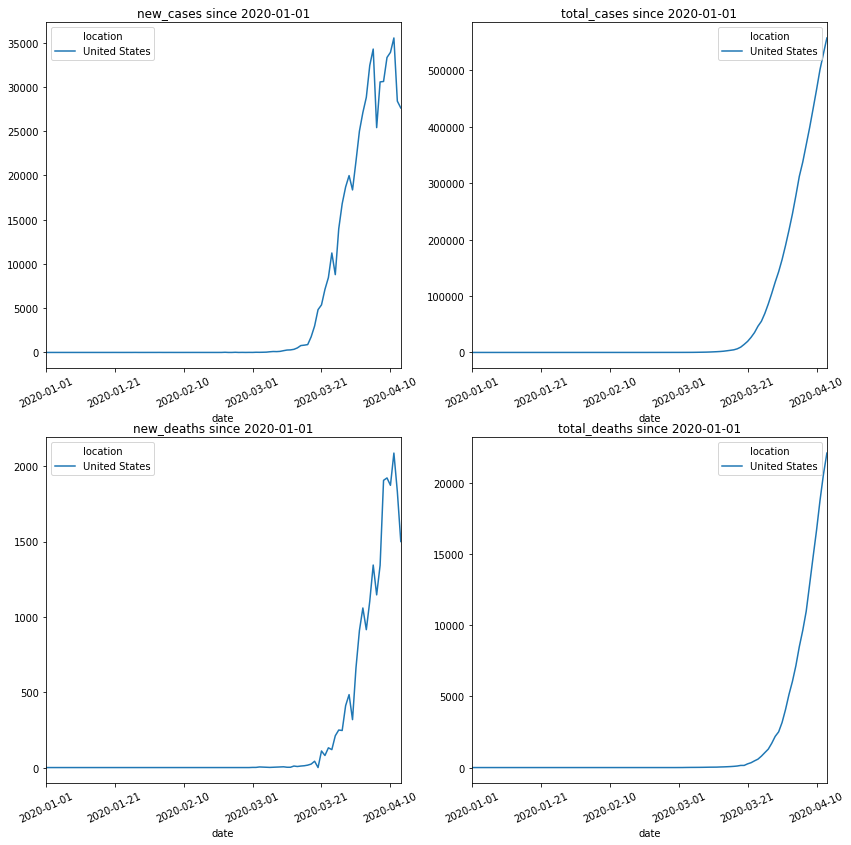

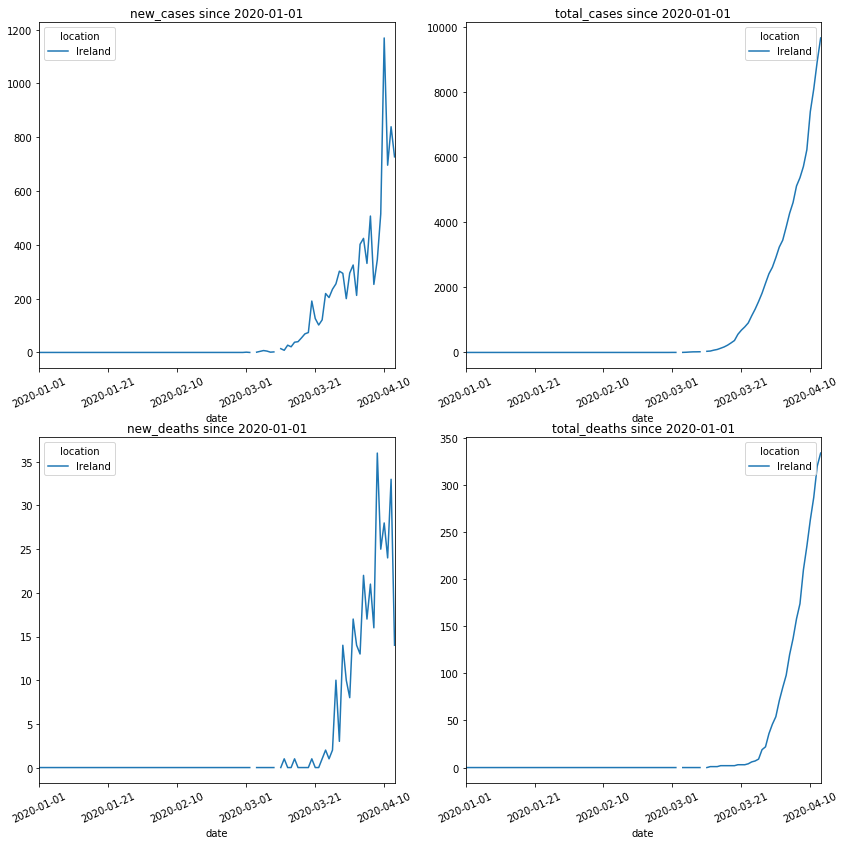

In [18]:
plt.rcParams["figure.figsize"] = (14, 14)
for country in [['China'], ['South Korea'], ['United States'], ['Ireland']]:
    fig, ax = plt.subplots(2,2)
    for values, axis in zip(['new_cases', 'total_cases', 'new_deaths', 'total_deaths'], [ax[0][0], ax[0][1], ax[1][0], ax[1][1]]):
        sub, title = covid(countries=country, since='2020-01-01', values=values)
        sub.iloc[:,:20].plot(title=title, logy=False, ax=axis, rot=25)

### Normalized Charts
These charts are normalized so that each country's data is divided by the maximum value of that data over the entire series. In that way, each country's data peaks at 100%.

The intent here is not to compare absolute values, but just the shape of the curve. We see for example that China and South Korea rose to a peak and then tapered off (for new cases/deaths), whereas most other countries are still growing.

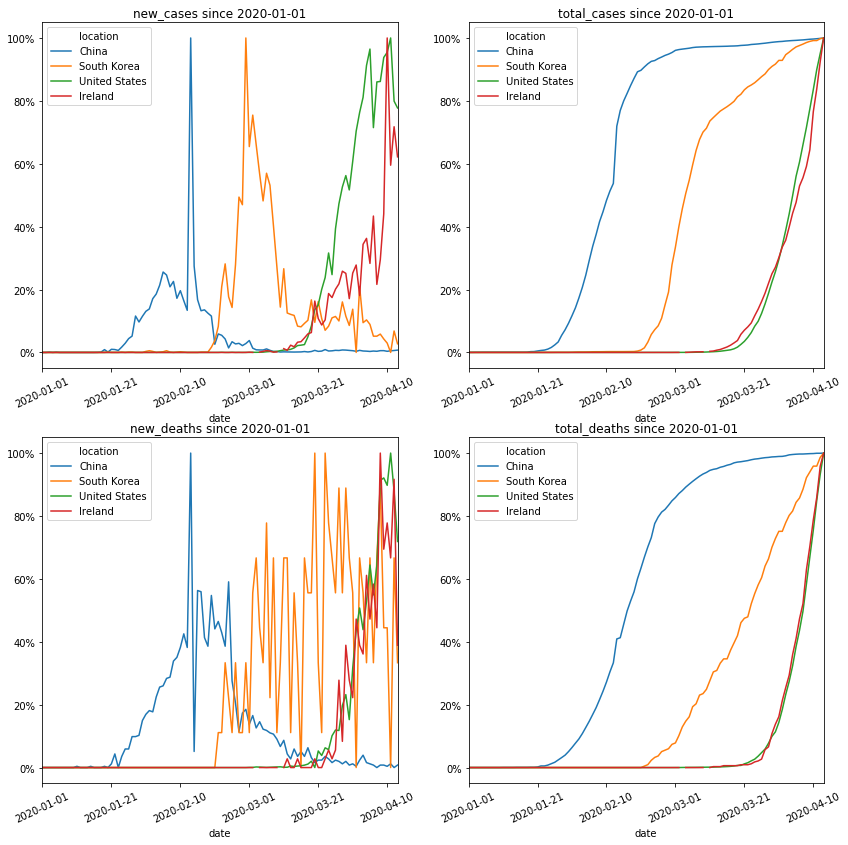

In [19]:
fig, ax = plt.subplots(2,2)
for values, axis in zip(['new_cases', 'total_cases', 'new_deaths', 'total_deaths'], [ax[0][0], ax[0][1], ax[1][0], ax[1][1]]):
    sub, title = covid(countries=['China','South Korea','United States', 'Ireland'], since='2020-01-01', values=values, sort=False)
    sub2 = sub/sub.max(axis=0)
    ax = sub2.plot(title=title, ax=axis, rot=25)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

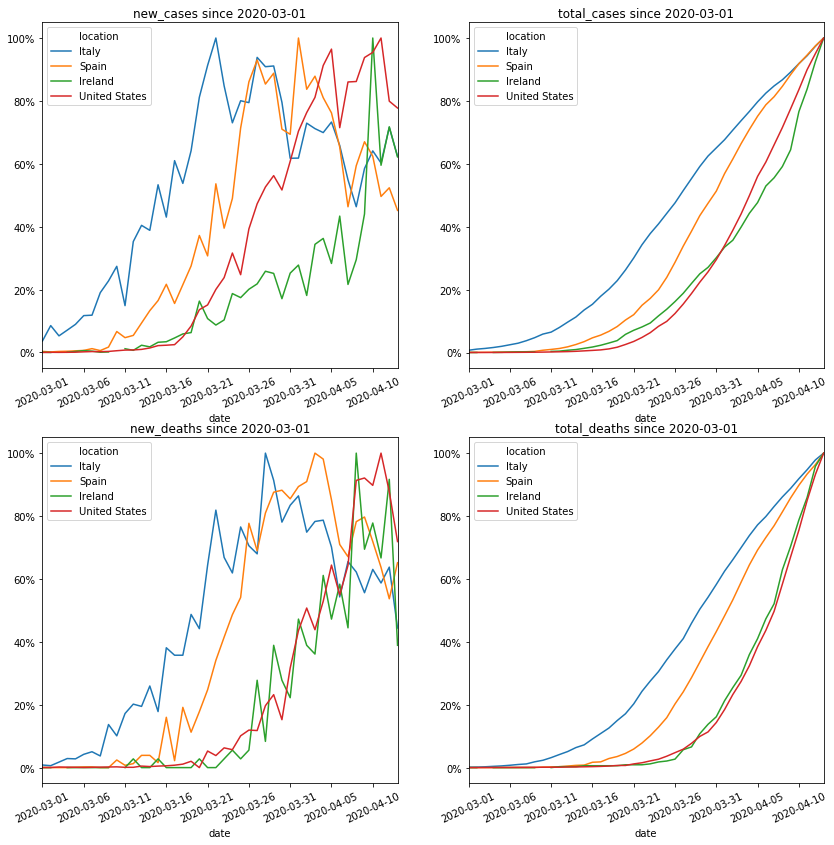

In [20]:
fig, ax = plt.subplots(2,2)
for values, axis in zip(['new_cases', 'total_cases', 'new_deaths', 'total_deaths'], [ax[0][0], ax[0][1], ax[1][0], ax[1][1]]):
    sub, title = covid(countries=['Italy','Spain','Ireland', 'United States'], since='2020-03-01', values=values, sort=False)
    sub2 = sub/sub.max(axis=0)
    ax = sub2.plot(title=title, ax=axis, rot=25)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

### Other View

In [21]:
#    fig, ax = plt.subplots(2,2)
#    for values, axis in zip(['new_cases', 'total_cases', 'new_deaths', 'total_deaths'], [ax[0][0], ax[0][1], ax[1][0], ax[1][1]]):
#        sub, title = covid(countries=country, since='2020-01-01', values=values)
#        sub.iloc[:,:20].plot(title=title, logy=False, ax=axis, rot=25)

def covid2(start='2020-03-01', end='2021-01-01', countries=['Ireland']):
    for country in countries:
        df2 = df
        df2 = df2[df.location==country]
        df2 = df2[df2.date >= start]
        df2 = df2[df2.date <= end]
        latest_row = df2.shape[0]-1
        latest_date = df2.index[latest_row]
        df2 = df2.set_index('date')
        
        fig, ax = plt.subplots(2, 1, linewidth=5, edgecolor='black')

        for value, axis in zip(['cases', 'deaths'], [ax[0], ax[1]]):
            title = value + ' in ' + country + ' from ' + start + ' to ' + end
            ax1 = df2['new_'+value].plot(legend=True,title=title,ax=axis,rot=20)
            ax1.set_ylabel('new')
            ax1.grid(color='grey', linestyle='-', linewidth=0.5, alpha=0.5, axis='both')
            ax2 = df2['total_'+value].plot(legend=True,secondary_y=True,ax=axis,rot=20)
            ax2.set_ylabel('total')
            ax2.grid(color='grey', linestyle='-', linewidth=0.5, alpha=0.5, axis='both')


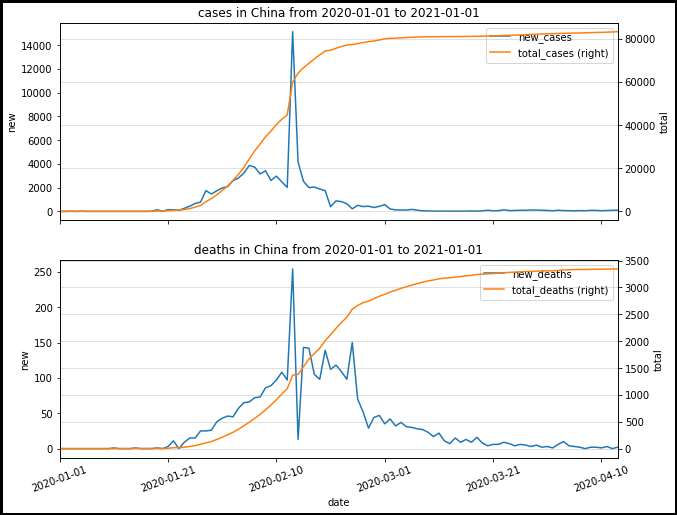

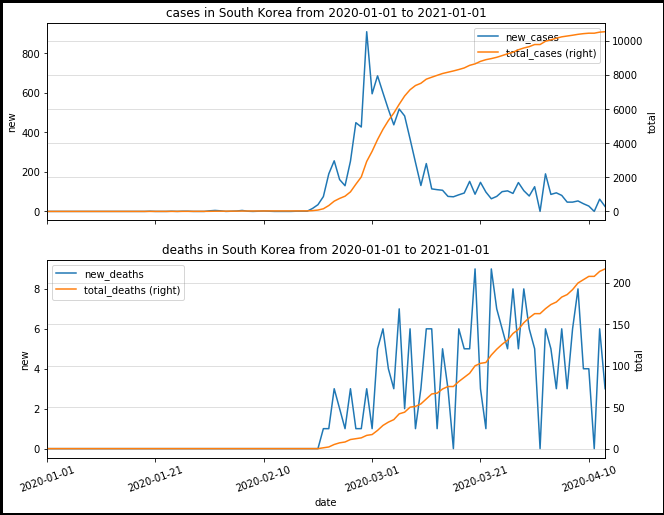

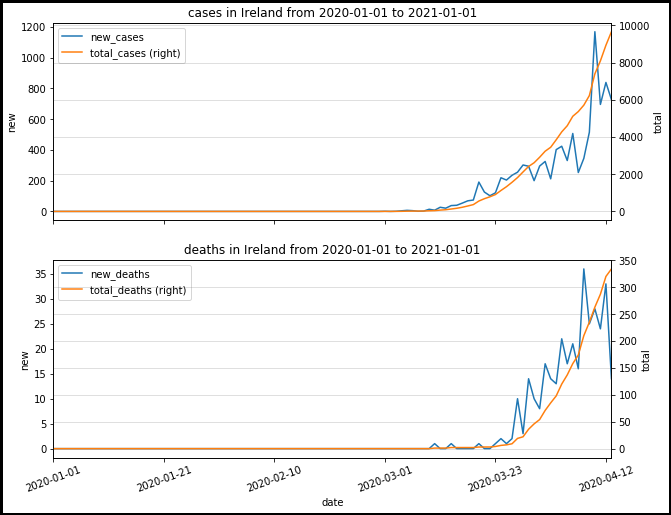

In [22]:
plt.rcParams["figure.figsize"] = (10, 8)
covid2(countries=['China', 'South Korea','Ireland'], start='2020-01-01')